#03.Kaggle

# 목차

-  Project1. Load_digits: 손글씨 분류

    - Step (0) 필요한 모듈 import하기
    - Step (1) 데이터 준비
    - Step (2) 간단한 전처리
    - Step (3) 모델 튜닝


회고

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

## 1. 데이터 살펴보기
pandas의 read_csv 함수를 사용해 데이터를 읽어오고, 각 변수들이 나타내는 의미를 살펴보기
1. ID : 집을 구분하는 번호
2. date : 집을 구매한 날짜
3. price : 타겟 변수인 집의 가격
4. bedrooms : 침실의 수
5. bathrooms : 침실당 화장실 개수
6. sqft_living : 주거 공간의 평방 피트
7. sqft_lot : 부지의 평방 피트
8. floors : 집의 층 수
9. waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
10. view : 집이 얼마나 좋아 보이는지의 정도
11. condition : 집의 전반적인 상태
12. grade : King County grading 시스템 기준으로 매긴 집의 등급
13. sqft_above : 지하실을 제외한 평방 피트
14. sqft_basement : 지하실의 평방 피트
15. yr_built : 집을 지은 년도
16. yr_renovated : 집을 재건축한 년도
17. zipcode : 우편번호
18. lat : 위도
19. long : 경도
20. sqft_living15 : 2015년 기준 주거 공간의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)
21. sqft_lot15 : 2015년 기준 부지의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)

In [2]:
train = pd.read_csv("/content/drive/MyDrive/DL/Exp3/train.csv")
test = pd.read_csv("/content/drive/MyDrive/DL/Exp3/test.csv")
print('train data dim : {}'.format(train.shape))
print('test data dim : {}'.format(test.shape))

train data dim : (15035, 21)
test data dim : (6468, 20)


In [3]:
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


## 2. 간단한 전처리 
각 변수들에 대해 결측 유무를 확인하고, 분포를 확인해보면서 간단하게 전처리를 하겠습니다.
### id, date 변수 정리
id 변수는 모델이 집값을 예측하는데 도움을 주지 않으므로 제거합니다.<br>
date 변수는 연월일시간으로 값을 가지고 있는데, 연월만 고려하는 범주형 변수로 만들겠습니다.

In [4]:
train['date'] = train['date'].apply(lambda i: i[:6]).astype(int)
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,201410,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,201502,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,201502,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,201406,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,201501,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [5]:
y = train['price']
del train['price']

print(train.columns)

Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [6]:
del train['id']

print(train.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [7]:
test['date'] = test['date'].apply(lambda i: i[:6]).astype(int)

del test['id']

print(test.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [8]:
y

0         221900.0
1         180000.0
2         510000.0
3         257500.0
4         291850.0
           ...    
15030     610685.0
15031    1007500.0
15032     360000.0
15033     400000.0
15034     325000.0
Name: price, Length: 15035, dtype: float64

### 가격 데이터의 분포도 확인
한쪽으로 치우친 분포는 모델이 결과를 예측하기에 좋지 않은 영향을 미치므로 다듬어줄 필요가 있습니다.

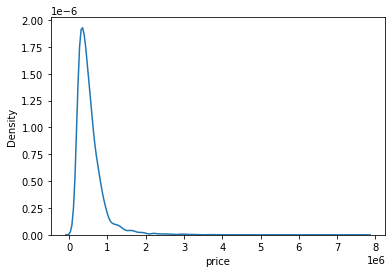

In [9]:
"""
seaborn의 `kdeplot`을 활용해 `y`의 분포를 확인해주세요!
"""
sns.kdeplot(y)
plt.show()

In [10]:
y = np.log1p(y)
y

0        12.309987
1        12.100718
2        13.142168
3        12.458779
4        12.583999
           ...    
15030    13.322338
15031    13.822984
15032    12.793862
15033    12.899222
15034    12.691584
Name: price, Length: 15035, dtype: float64

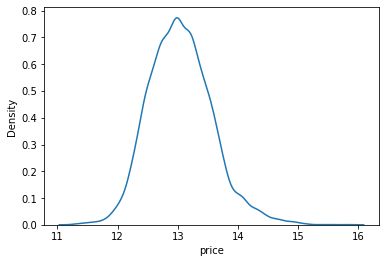

In [11]:
sns.kdeplot(y)
plt.show()

In [12]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15035 entries, 0 to 15034
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           15035 non-null  int64  
 1   bedrooms       15035 non-null  int64  
 2   bathrooms      15035 non-null  float64
 3   sqft_living    15035 non-null  int64  
 4   sqft_lot       15035 non-null  int64  
 5   floors         15035 non-null  float64
 6   waterfront     15035 non-null  int64  
 7   view           15035 non-null  int64  
 8   condition      15035 non-null  int64  
 9   grade          15035 non-null  int64  
 10  sqft_above     15035 non-null  int64  
 11  sqft_basement  15035 non-null  int64  
 12  yr_built       15035 non-null  int64  
 13  yr_renovated   15035 non-null  int64  
 14  zipcode        15035 non-null  int64  
 15  lat            15035 non-null  float64
 16  long           15035 non-null  float64
 17  sqft_living15  15035 non-null  int64  
 18  sqft_l

#3.모델튜닝

## RMSE 계산

In [13]:
## RMSE 계산

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [14]:
def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

In [15]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

In [16]:
# random_state는 모델초기화나 데이터셋 구성에 사용되는 랜덤 시드값 
#random_state=None (초기값) 아무것도 지정하지 않고 None을 넘겨주면 모델 내부에서 임의로 선택합니다.  
random_state=2020         

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]


In [17]:
gboost.__class__.__name__

'GradientBoostingRegressor'

In [18]:
xgboost.__class__.__name__

'XGBRegressor'

In [19]:
lightgbm.__class__.__name__

'LGBMRegressor'

In [20]:
rdforest.__class__.__name__

'RandomForestRegressor'

In [21]:
df = {}

for model in models:
    # 모델 이름 획득
    model_name = model.__class__.__name__

    # train, test 데이터셋 분리 - 여기에도 random_state를 고정
    X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)

    # 모델 학습
    model.fit(X_train, y_train)
    
    # 예측
    y_pred = model.predict(X_test)

    # 예측 결과의 rmse값 저장
    df[model_name] = rmse(y_test, y_pred)
    
    # data frame에 저장
    score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
    
df

[13:03:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


{'GradientBoostingRegressor': 128360.19649691365,
 'LGBMRegressor': 111920.36735892233,
 'RandomForestRegressor': 125487.07102453562,
 'XGBRegressor': 131067.44622809246}

In [22]:
def get_scores(models, train, y):

  df = {}

  for model in models:
    model_name = model.__class__.__name__

    X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    df[model_name] = rmse(y_test, y_pred)
    score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
      
  return score_df

get_scores(models, train, y)

[13:03:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


,RMSE
XGBRegressor,131067.446228
GradientBoostingRegressor,128360.196497
RandomForestRegressor,125487.071025
LGBMRegressor,111920.367359


## 그리드 탐색 

In [23]:
from sklearn.model_selection import GridSearchCV

In [24]:
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [1, 10]
}

In [25]:
model = LGBMRegressor(random_state=random_state)

In [26]:
grid_model = GridSearchCV(model, param_grid=param_grid, \
                        scoring='neg_mean_squared_error', \
                        cv=5, verbose=0, n_jobs=5)

grid_model.fit(train, y)

GridSearchCV(cv=5, estimator=LGBMRegressor(random_state=2020), n_jobs=5,
             param_grid={'max_depth': [1, 10], 'n_estimators': [50, 100]},
             scoring='neg_mean_squared_error')

In [27]:
grid_model.cv_results_

{'mean_fit_time': array([0.28225627, 0.3637064 , 0.95409474, 1.49642677]),
 'mean_score_time': array([0.02504964, 0.03781133, 0.04735413, 0.06504588]),
 'mean_test_score': array([-0.07339447, -0.05502043, -0.02917734, -0.02702714]),
 'param_max_depth': masked_array(data=[1, 1, 10, 10],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_n_estimators': masked_array(data=[50, 100, 50, 100],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'max_depth': 1, 'n_estimators': 50},
  {'max_depth': 1, 'n_estimators': 100},
  {'max_depth': 10, 'n_estimators': 50},
  {'max_depth': 10, 'n_estimators': 100}],
 'rank_test_score': array([4, 3, 2, 1], dtype=int32),
 'split0_test_score': array([-0.0756974 , -0.05555652, -0.02885847, -0.02665428]),
 'split1_test_score': array([-0.07666447, -0.057876  , -0.03041465, -0.02795896]),
 'split2_test_score': array([-0.07354904, -0.05546079, 

In [28]:
params = grid_model.cv_results_['params']
params

[{'max_depth': 1, 'n_estimators': 50},
 {'max_depth': 1, 'n_estimators': 100},
 {'max_depth': 10, 'n_estimators': 50},
 {'max_depth': 10, 'n_estimators': 100}]

In [29]:
score = grid_model.cv_results_['mean_test_score']
score

array([-0.07339447, -0.05502043, -0.02917734, -0.02702714])

In [30]:
results = pd.DataFrame(params)
results['score'] = score

results

,max_depth,n_estimators,score
0,1,50,-0.073394
1,1,100,-0.055020
2,10,50,-0.029177
3,10,100,-0.027027


In [31]:
results['RMSE'] = np.sqrt(-1 * results['score'])
results

,max_depth,n_estimators,score,RMSE
0,1,50,-0.073394,0.270914
1,1,100,-0.055020,0.234564
2,10,50,-0.029177,0.170814
3,10,100,-0.027027,0.164399


In [32]:
results = results.rename(columns={'RMSE': 'RMSLE'})
results

,max_depth,n_estimators,score,RMSLE
0,1,50,-0.073394,0.270914
1,1,100,-0.055020,0.234564
2,10,50,-0.029177,0.170814
3,10,100,-0.027027,0.164399


In [33]:
results = results.sort_values('RMSLE')
results

,max_depth,n_estimators,score,RMSLE
3,10,100,-0.027027,0.164399
2,10,50,-0.029177,0.170814
1,1,100,-0.055020,0.234564
0,1,50,-0.073394,0.270914


In [34]:
"""
다음과 같은 과정을 진행할 수 있는 `my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)` 함수를 구현해 보세요.

1. GridSearchCV 모델로 `model`을 초기화합니다.
2. 모델을 fitting 합니다.
3. params, score에 각 조합에 대한 결과를 저장합니다. 
4. 데이터 프레임을 생성하고, RMSLE 값을 추가한 후 점수가 높은 순서로 정렬한 `results`를 반환합니다.
"""

def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    # GridSearchCV 모델로 초기화
    grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', \
                              cv=5, verbose=verbose, n_jobs=n_jobs)
    
    # 모델 fitting
    grid_model.fit(train, y)

    # 결과값 저장
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']
    
    # 데이터 프레임 생성
    results = pd.DataFrame(params)
    results['score'] = score
    
    # RMSLE 값 계산 후 정렬
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')

    return results



# 4.제출

In [35]:
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [1, 10],
    'num_leaves' : [25, 31], #default 31
    'learning_rate' : [0.1, 0.15],
    'min_child_samples' : [20, 30] # default 20
}

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 32 candidates, totalling 160 fits


,learning_rate,max_depth,min_child_samples,n_estimators,num_leaves,score,RMSLE
31,0.15,10,30,100,31,-0.026855,0.163876
27,0.15,10,20,100,31,-0.026855,0.163876
15,0.10,10,30,100,31,-0.026900,0.164013
26,0.15,10,20,100,25,-0.026943,0.164144
11,0.10,10,20,100,31,-0.027027,0.164399
30,0.15,10,30,100,25,-0.027194,0.164906
10,0.10,10,20,100,25,-0.027306,0.165244
14,0.10,10,30,100,25,-0.027408,0.165554
29,0.15,10,30,50,31,-0.028023,0.167401
25,0.15,10,20,50,31,-0.028048,0.167474


In [36]:
#learning_rate	max_depth	min_child_samples	n_estimators	num_leaves
#0.15	10	30	100	31	
model = LGBMRegressor(max_depth=10, n_estimators=100, learning_rate=0.15, min_child_samples= 30, num_leaves =31,  random_state=random_state)
model.fit(train, y)
prediction = model.predict(test)
prediction

array([13.12712582, 13.14094433, 14.11526638, ..., 13.05495792,
       12.72468065, 12.93837155])

In [37]:
prediction = np.expm1(prediction)
prediction
prediction.shape


(6468,)

Make Submission

In [38]:
submission = pd.read_csv("/content/drive/MyDrive/DL/Exp3/sample_submission.csv")
submission.head()

submission.shape

(6468, 2)

In [39]:
submission['price'] = prediction
submission.head()

,id,price
0,15035,5.023859e+05
1,15036,5.093763e+05
2,15037,1.349528e+06
3,15038,3.144715e+05
4,15039,3.319391e+05


In [40]:
"""
아래의 과정을 수행하는 `save_submission(model, train, y, test, model_name, rmsle)` 함수를 구현해 주세요.
1. 모델을 `train`, `y`로 학습시킵니다.
2. `test`에 대해 예측합니다.
3. 예측값을 `np.expm1`으로 변환하고, `submission_model_name_RMSLE_100000.csv` 형태의 `csv` 파일을 저장합니다.
"""

import os 
from  os.path import join

def save_submission(model, train, y, test, model_name, rmsle=None):
    model.fit(train, y)
    prediction = model.predict(test)
    prediction = np.expm1(prediction)
    data_dir = '/content/drive/MyDrive/DL/Exp3'
    submission_path = join(data_dir, 'sample_submission.csv')
    submission = pd.read_csv(submission_path)
    submission['price'] = prediction
    submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, model_name, rmsle)
    submission.to_csv(submission_csv_path, index=False)
    print('{} saved!'.format(submission_csv_path))

save_submission(model, train, y, test, 'LGBM' )

/content/drive/MyDrive/DL/Exp3/submission_LGBM_RMSLE_None.csv saved!


# 회고



### - 이번 프로젝트에서 **어려웠던 점**.

많이 어려웠어요.


### - 프로젝트를 진행하면서 **알아낸 점** 혹은 **아직 모호한 점**.

{알아낸점}

그리드 서치

1. Grid search 란 무엇인가?

컨셉  : 모델에게 가장 적합한 하이퍼 파라미터를 찾기 

Grid search (격자 탐색) 은 모델 하이퍼 파라미터에 넣을 수 있는 값들을 순차적으로 입력한뒤에 가장 높은 성능을 보이는 하이퍼 파라미터들을 찾는 탐색 방법이다.
모델을 학생에 비유해보자면, 하루에 몇쪽 풀고 모의고사 칠지, 몇번씩 보고 다음페이지 넘어갈지 어디까지 깊게 공부할지 등등이 세부적인 규율이 하이퍼 파라미터이다. 그리고 그리드 서치는 그 세부적인 규율을 일일히 다 적용해봐가면서 어떤 규율이 가장 이 공부법(모델)에 적합한지 판단하는 것입니다. 

[출처] 머신러닝 Grid Search, 앙상블, 랜덤포레스트, 하이퍼 파라미터 튜닝 정의 및 null값 처리하는 방법6|작성자 라스트픽


2. 그리드 서치 과정
  
  1) 탐색할 매개변수 지정하기

  2) 훈련세트에서 그리드 서치를 수행하여 최상의 평균 점수가 나오는 매개변수 조합을 찾는다.

  3) 그리드 서치는 최상의 매개변수에서 전체 훈련 세트를 사용해 최종 모델을 다시 훈련한다.

  4) 이 모델도 그리드 서치 모델에 적용된다.

[출처] 교차 검증(cross validation)과 그리드 서치(grid search)|작성자 안도감

{모호한점}



### - 루브릭 평가 지표를 맞추기 위해 **시도한 것들**.

>#### **루브릭**
>|번호|평가문항|상세기준|
>|:---:|---|---|
>|1| 캐글 데이터분석 전과정이 성공적으로 진행되었다.|데이터 전처리, 모델학습, 예측의 전체 과정을 거쳐 캐글 submission까지 진행되었다.|
>|2|전처리, 학습과정 및 결과에 대한 설명이 시각화를 포함하여 체계적으로 진행되었다.| 제출된 노트북이 캐글 커널로 사용될 수 있을 만큼 전처리, 학습, 최적화 진행 과정이 체계적으로 기술되었다.|
>|3|회귀모델 예측정확도가 기준 이상 높게 나오지 않았다.|다양한 피처 엔지니어링과 하이퍼 파라미터 튜닝 등의 최적화 기법을 통해 **캐글 리더보드의 Private score 기준 110000 이하의 점수**를 얻었다|
private score 115807.04439


### - **자기 다짐**
* 코드 10번 읽어보기 
* 친구한테 설명해본다 
* 앙상블기법에 대해 더 공부하기 



### - **참고**

그리드 서치 : https://blog.naver.com/lastpick1004/222674772707


ligthbgm
https://blog.naver.com/geniusjohn95/222628776854

XGboost, LGBM, CatBoost
https://blog.naver.com/dlekdms7931/222719354333

K-fold 교차검증
https://blog.naver.com/jiwon1217ok/222653061441

람다 :
https://blog.naver.com/helloyoujin_/222790020378

astype:
https://blog.naver.com/applewoods/222648404673
